<a href="https://colab.research.google.com/github/PadmarajBhat/Machine-Learning/blob/master/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of 3 Brain Tumors (Meningioma, Glioma and Pituitary) in T1-weighted contrast enhanced images

### - Revisitng the Udacity Capstone Project in pursuit of better accuracy



# What is the problem statement?
  * predict the tumor class given only MRI image
  * OR predict the tumor class when both MRI and Tumor region is given !!!
      * tumor region is identified and put in input dataset by experts
          * can we have Image Segmentation problem ?


  * I think this is the order of problem from easy level to difficult level
    * Identify the tumor class from raw MRI image (here accuracy may be low)
    * Identify the tumor class from raw MRI image + tumor region identified (here accuracy may be better)
    * Auto detect the tumor segment in a MRI image and classify the tumor (ideal application for a radiologist)

    Let us try all the 3 !!!

# Import Packages
* read the input MRI images (.mat) files through ***h5py***
* ***pandas*** for data analysis and preprocessing
* ***tensorflow*** for modelling and predicting

In [0]:
import os
import zipfile
import h5py
import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

# Load Data
* Mount Google Drive
* Unzip it in colab disk
* load mat attributes to list of tuples
* create a panda dataframe for analysis

##### Issues Faced:
1. loading to panda with image took half(6GB) of RAM
* loading tumor along with mri image (as in mat file) crashed the colab
  * Solution: let us load image but save only 5 point summary for both mri image and tumor

2. How do we scale/normalize the data?
  * would tumor region have 0 in it ?
    * only way to know is through the value present in the binary indicator == 1
        * implementation through 2 for loops takes forever !!!
          * need to implement throuhg np.where
        

3. Some images are less than 512
    * pad the difference with 0s.
    
4. Should tumor image be scaled between 0 -1? For now, brightness values are relative to that of the whole image to which it belongs to.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls /content/drive/'My Drive'/1512427

brainTumorDataPublic_1533-2298.zip  brainTumorDataPublic_767-1532.zip
brainTumorDataPublic_1-766.zip	    cvind.mat
brainTumorDataPublic_2299-3064.zip  README.txt


In [4]:
!ls /content/drive/'My Drive'/1512427/brainTumorDataPublic_1-766.zip

'/content/drive/My Drive/1512427/brainTumorDataPublic_1-766.zip'


### Load Image Array

In [0]:
def retrieveImage(file_name):
  f = h5py.File(file_name,'r')
  mri_image = np.array(f['cjdata']['image'],dtype=np.float128)
  if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
  return mri_image/mri_image.max()

### Load Tumor Array

In [0]:
def retrieveTumorImage(file_name):
  f = h5py.File(file_name,'r')
  mri_image = np.array(f['cjdata']['tumorMask'],dtype=np.float128)
  if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
  return mri_image/mri_image.max()

### Load Image and Tumor Statistics to Panda

In [0]:
def return_imageInfo_from_mat_file(file_name):
    f = h5py.File(file_name,'r')

    mri_image = np.array(f['cjdata']['image'],dtype=np.float128)
    #scaler = MinMaxScaler(feature_range=(1,2))
    #mri_image = scaler.fit(mri_image)
    mri_image = mri_image/mri_image.max()

    if mri_image.shape[0] < 512:
      print("Shape of the image : ", mri_image.shape)
      mri_image = np.pad(mri_image,(512 - mri_image.shape[0])//2,'constant',constant_values=0)
    
    temp_mri_image = np.copy(mri_image)
    temp_mri_image[temp_mri_image == 0 ] = 2

    mri_quartiles = np.percentile(mri_image[mri_image > 0], [25, 50, 75])

    tumor_image = np.array(f['cjdata']['tumorMask'], dtype=np.float128)
    if tumor_image.shape[0] < 512:
      print("Shape of the tumor image : ", tumor_image.shape)
      tumor_image = np.pad(tumor_image,(512 - tumor_image.shape[0])//2,'constant',constant_values=0)
    
    tumor_image = temp_mri_image * tumor_image
    tumor_image = tumor_image[tumor_image > 0]
    tumor_image[tumor_image == 2] = 0

    '''tumor_array =[]
    for i in range(0,512):
      for j in range(0,512):
        if tumor_image[i][j]:
          tumor_array.append(mri_image[i][j])

    tumor_image = np.array(tumor_array, dtype=np.float)'''

    tumor_quartiles = np.percentile(tumor_image, [25, 50, 75])

    return np.array(f['cjdata']['PID'],dtype=np.int)[0][0] \
            ,mri_image.min() \
            ,mri_image.max() \
            ,mri_quartiles[1] \
            ,mri_quartiles[0] \
            ,mri_quartiles[2] \
            ,tumor_image.min() \
            ,tumor_image.max() \
            ,tumor_quartiles[1] \
            ,tumor_quartiles[0] \
            ,tumor_quartiles[2] \
            ,tumor_image.shape \
            ,file_name\
            ,np.array(f['cjdata']['label'], dtype=np.int)[0][0] 

In [0]:
def loadDf():
  patients_details = []
  for root, dirs, files in os.walk("/content/drive/My Drive/1512427/", topdown = False):
    for f in files:
      if ".zip" in f:
          file = zipfile.ZipFile(root+f, "r")
          for name in file.namelist():
            file.extract(name,".")
            patients_details.append(return_imageInfo_from_mat_file(name))
          #break
      #break
  mri_col_names = ["mri_min","mri_max","mri_median","mri_1q", "mri_3q"]
  tumor_col_names = ["t_min","t_max","t_median","t_1q","t_3q","tumor_size"]
  col_names = ["pid"] + mri_col_names + tumor_col_names+ ["file_name","label"]
  return pd.DataFrame(patients_details,columns=col_names)


In [0]:

tumor_names = ["","Meningioma","Glioma","Pituitary"]

In [10]:

df = loadDf()
df["square_shape"] = df.tumor_size.apply(lambda x: np.sqrt(x[0]))
df.sample(20)

Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (256, 256)
Shape of the image :  (256, 256)
Shape of the tumor image :  (25

,pid,mri_min,mri_max,mri_median,mri_1q,mri_3q,t_min,t_max,t_median,t_1q,t_3q,tumor_size,file_name,label,square_shape
1211,77,0.0,1.0,0.114815,0.020044,0.273203,0.087146,0.630937,0.242702,0.205011,0.290795,"(6302,)",1978.mat,2,79.385137
1608,77,0.0,1.0,0.016030,0.007038,0.223120,0.119380,0.392936,0.173791,0.154307,0.198814,"(880,)",2375.mat,2,29.664794
1327,77,0.0,1.0,0.210037,0.011964,0.227650,0.074443,0.458624,0.230974,0.199402,0.256896,"(4581,)",2094.mat,2,67.683085
934,49,0.0,1.0,0.207424,0.093886,0.272926,0.147380,0.538210,0.377729,0.330786,0.421397,"(1101,)",1701.mat,3,33.181320
432,49,0.0,1.0,0.159004,0.017720,0.281130,0.070881,0.442529,0.358477,0.300287,0.398467,"(836,)",489.mat,1,28.913665
1431,77,0.0,1.0,0.195577,0.012182,0.257680,0.100768,0.589645,0.304952,0.257184,0.369273,"(8030,)",2198.mat,2,89.610267
715,49,0.0,1.0,0.223045,0.017180,0.300652,0.071386,0.768069,0.249704,0.220379,0.287915,"(19296,)",743.mat,2,138.910043
302,49,0.0,1.0,0.194702,0.015480,0.314413,0.108703,0.595803,0.469900,0.420709,0.503698,"(1764,)",371.mat,1,42.000000
2776,49,0.0,1.0,0.161667,0.053333,0.286667,0.238333,0.701667,0.486667,0.451667,0.525000,"(666,)",1478.mat,3,25.806976
1338,77,0.0,1.0,0.151738,0.011374,0.254233,0.030891,0.421481,0.159623,0.146051,0.174357,"(6371,)",2105.mat,2,79.818544


# Analysis


## Statistical Analysis
* Number of patients in the dataset
* Patient wise distribution of tumor classes
* Comparison of below attributes for the 3 tumor classes
  * 1st quantile of MRI image
  * Median of the MRI image
  * 3rd quantile of the MRI image
  * min value distribution of the Tumor
  * max value distribution of the Tumor
  * 1st quantile of the Tumor
  * median of the Tumor
  * 3rd quantile of the Tumor
    * Analysis: 
      * All tumors have darkest area which may indicate the tumor itself
      * All tumors have uniform distribution of brightness (apart from the dark area)
      * MRI images have darker area outside the skull (non scan area)
          * will this influence the model ?
          * should the color of the tumor and the non important area of the MRI scan be different ?
          
* 256x256 image size distribution (any bias in there ?)

##### Issues Faced:
* Bokeh plots are interactive but they consume a lot of space(>100mb) in the notebook 
  * markdown for now, when interested can be seen by enabling it as code cell

In [11]:
df.pid.unique()

array([49, 57, 53, 77, 56])

There are only 5 patients info present !!!!

In [12]:
df.groupby("pid").agg("count").reset_index()[['pid','mri_min']]

,pid,mri_min
0,49,1427
1,53,2
2,56,13
3,57,401
4,77,1221


In [13]:
df.groupby(["pid","label"]).agg("count").reset_index()[['pid','label','mri_min']]

,pid,label,mri_min
0,49,1,584
1,49,2,126
2,49,3,717
3,53,1,1
4,53,3,1
5,56,1,1
6,56,2,12
7,57,1,122
8,57,2,67
9,57,3,212


In [14]:
df.groupby("label").agg("count").reset_index()[['label','pid']]

,label,pid
0,1,708
1,2,1426
2,3,930


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


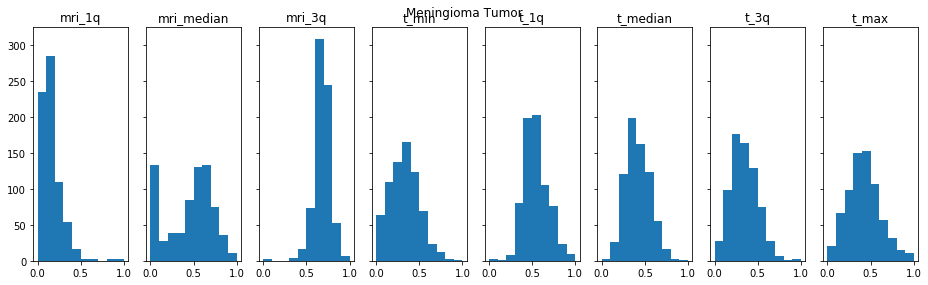

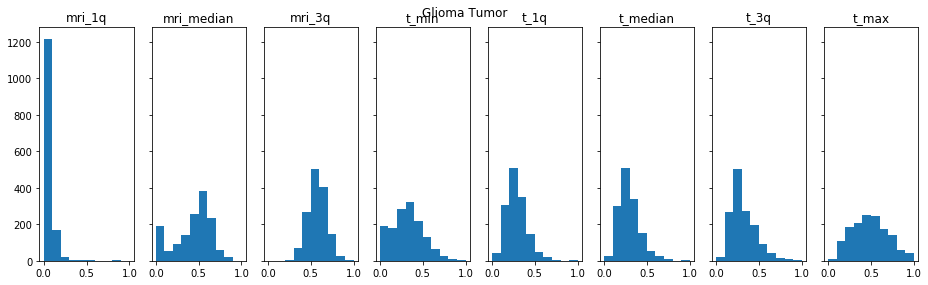

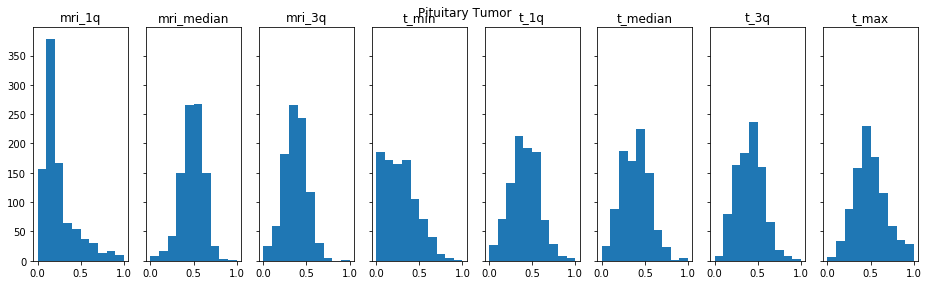

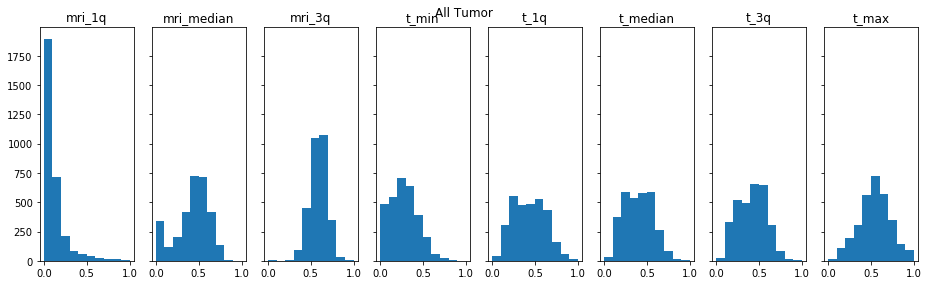

In [15]:
def plotStatistics(df, tumor_name):
  df = df[["mri_1q","mri_median","mri_3q","t_min","t_1q","t_median","t_3q","t_max"]]
  df=(df-df.min())/(df.max()-df.min())
  fig, ax = plt.subplots(1, 8,sharex=True,sharey=True,tight_layout=True)
  fig.set_figheight(4)
  fig.set_figwidth(13)
  
  fig.suptitle(tumor_name+" Tumor")
  #plt.subplot(1,8,1)
  ax[0].hist(df.mri_1q.tolist())
  ax[0].set_title("mri_1q")
  #plt.subplot(1,8,2)
  ax[1].hist(df.mri_median.tolist())
  ax[1].set_title("mri_median")
  #plt.subplot(1,8,3)
  ax[2].hist(df.mri_3q.tolist())
  ax[2].set_title("mri_3q")
  #plt.subplot(1,8,4)
  ax[3].hist(df.t_min.tolist())
  ax[3].set_title("t_min")
  #plt.subplot(1,8,5)
  ax[4].hist(df.t_1q.tolist())
  ax[4].set_title("t_1q")
  #plt.subplot(1,8,6)
  ax[5].hist(df.t_median.tolist())
  ax[5].set_title("t_median")
  #plt.subplot(1,8,7)
  ax[6].hist(df.t_3q.tolist())
  ax[6].set_title("t_3q")
  #plt.subplot(1,8,8)
  ax[7].hist(df.t_max.tolist())
  ax[7].set_title("t_max")
  plt.show()

plotStatistics(df[df.label ==1], tumor_names[1])
plotStatistics(df[df.label ==2], tumor_names[2])
plotStatistics(df[df.label ==3], tumor_names[3])
plotStatistics(df, "All")

## Visual Analysis

### Smallest Tumor Sample

plt.imshow(retrieveImage(list(df[df.tumor_size == df.tumor_size.min()]['file_name'])[0]));
plt.imshow(retrieveTumorImage(list(df[df.tumor_size == df.tumor_size.min()]['file_name'])[0]),alpha=0.5);
plt.show()


### Biggest Tumor in the Dataset

plt.imshow(retrieveImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]));
plt.imshow(retrieveTumorImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]),alpha=0.5);
plt.show()


### Numpy Resize failed

plt.imshow(np.resize(retrieveImage(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0]),(256,256)));
plt.show()

### Bokeh Plot

def bokehPlot(file_name, tumor_label):
  tumor_names = ["","Meningioma","Glioma","Pituitary"]
  im = retrieveImage(file_name)
  s1 = figure(width=512, plot_height=512, title=tumor_names[tumor_label]+" MRI Image")
  s1.image([im],x=[0],y=[0],dw=[512],dh=[512])

  im2 = retrieveTumorImage(file_name)

  s2 = figure(width=500, plot_height=500, title=tumor_names[tumor_label]+" MRI Image with Tumor Highlighted")
  s2.image([im2],x=[0],y=[0],dw=[512],dh=[512])
  s2.image([im],x=[0],y=[0],dw=[512],dh=[512],global_alpha=0.5)

  show(row(s1,s2))

bokehPlot(list(df[df.tumor_size == df.tumor_size.max()]['file_name'])[0], list(df[df.tumor_size == df.tumor_size.max()]['label'])[0])

#### Meningioma Plots

for fname in list(df[df.label == 1].sample(3)["file_name"]):
  bokehPlot(fname,1)

#### Glioma Plots

for fname in list(df[df.label == 2].sample(3)["file_name"]):
  bokehPlot(fname,2)

#### Pituitary Plots

for fname in list(df[df.label == 3].sample(3)["file_name"]):
  bokehPlot(fname,3)

# Preprocessing


Preprocessing ideas:

1.  Dataset has tumor region indicator which would allow us to get the average brightness of the area.

2. It is said that brightest region is skull and skull is not important for the tumor detection. It is only brain position determines the tumor class. If we remove skull remaining image is brain ?

3. if we start with a window of image which would maximize the presence of tumor and expand to include some brain region around the tumor then i guess it is the best data for training(and predicting). Because tumor position in brain is THE factor that decides the tumor class.

4. what is the optimum batch size for training?

5. what is the overall Image augumented training dataset size ?



## Batch Creation

In [16]:
df.groupby("label").agg("count").reset_index()

,label,pid,mri_min,mri_max,mri_median,mri_1q,mri_3q,t_min,t_max,t_median,t_1q,t_3q,tumor_size,file_name,square_shape
0,1,708,708,708,708,708,708,708,708,708,708,708,708,708,708
1,2,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426
2,3,930,930,930,930,930,930,930,930,930,930,930,930,930,930


In [18]:
def returnBatchIndices(df,batch_size):
  label_1 = df[df.label == 1].index.tolist()
  label_2 = df[df.label == 2].index.tolist()
  label_3 = df[df.label == 3].index.tolist()

  label_list = []
  #print(len(label_1), len(label_2),len(label_3),list(range(0,max(len(label_1),len(label_2),len(label_3)),batch_size)))
  for i in range(0,max(len(label_1),len(label_2),len(label_3)),batch_size):
    label_list.append(label_1[i:i+batch_size] + label_2[i:i+batch_size] + label_3[i:i+batch_size])
  return label_list

#yieldbatch(df,5)
for batch in returnBatchIndices(df,5):
  print(batch)


[0, 1, 2, 3, 4, 122, 124, 684, 685, 686, 544, 677, 679, 680, 681]
[5, 6, 7, 8, 9, 687, 688, 690, 691, 692, 682, 683, 766, 767, 768]
[10, 11, 12, 13, 14, 693, 694, 695, 696, 697, 769, 770, 771, 772, 773]
[15, 16, 17, 18, 19, 698, 699, 701, 702, 703, 774, 775, 776, 777, 778]
[20, 21, 22, 23, 24, 704, 705, 706, 707, 708, 779, 780, 781, 782, 783]
[25, 26, 27, 28, 29, 709, 710, 712, 713, 714, 784, 785, 786, 787, 788]
[30, 31, 32, 33, 34, 715, 716, 717, 718, 719, 789, 790, 791, 792, 793]
[35, 36, 37, 38, 39, 720, 721, 723, 724, 725, 794, 795, 796, 797, 798]
[40, 41, 42, 43, 44, 726, 727, 728, 729, 730, 799, 800, 801, 802, 803]
[45, 46, 47, 48, 49, 731, 732, 734, 735, 736, 804, 805, 806, 807, 808]
[50, 51, 52, 53, 54, 737, 738, 739, 740, 1074, 809, 810, 811, 812, 813]
[55, 56, 57, 58, 59, 1075, 1076, 1077, 1078, 1079, 814, 815, 816, 817, 818]
[60, 61, 62, 63, 64, 1080, 1081, 1082, 1083, 1084, 819, 820, 821, 822, 823]
[65, 66, 67, 68, 69, 1085, 1086, 1087, 1088, 1089, 824, 825, 826, 827, 828]


In [19]:
df[df.index == 648]

,pid,mri_min,mri_max,mri_median,mri_1q,mri_3q,t_min,t_max,t_median,t_1q,t_3q,tumor_size,file_name,label,square_shape
648,57,0.0,1.0,0.235238,0.022857,0.318095,0.04,0.527143,0.388571,0.350952,0.424286,"(10774,)",683.mat,1,103.797881


In [20]:
for i in [1,2,3,4,5]:
  print(i)

1
2
3
4
5


In [30]:
def returnABatch(df,batch_size):
  #returns a balanced label mri images
  index_list = returnBatchIndices(df,batch_size)
  #print("index list",len(list(index_list)))
  
  for j in index_list:
    batch_images=[]
    batch_labels=[]
    print("j",j)
    for i in j:
      print("i",i)
      batch_images.append(retrieveImage(list(df[df.index == i]['file_name'])[0]))
      batch_labels.append(df[df.index == i]['label'].tolist()[0])
      print("Batches :",len(batch_images),len(batch_labels))
    yield batch_images, batch_labels

for i in returnABatch(df.reset_index(),2)  :
  print(len(i),len(i[1]))
  break

j [0, 1, 122, 124, 544, 677]
i 0
Batches : 1 1
i 1
Batches : 2 2
i 122
Batches : 3 3
i 124
Batches : 4 4
i 544
Batches : 5 5
i 677
Batches : 6 6
2 6


#Model Building
* CNN Approach using Tensorflow keras

# Model Testing
* is the model bias for 256 size images ?
* is there any imbalance in 256 size images ?
* converting 512x512 to 256x256 size would definitely speed up the process but would it impact the accuracy ?
* is the model has better accuracy for any type of tumor class? (as we have imbalanced set ?